<a href="https://colab.research.google.com/github/NajmiAqil/TugasAkhir/blob/main/percobaanTA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("divg07/casia-20-image-tampering-detection-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'casia-20-image-tampering-detection-dataset' dataset.
Path to dataset files: /kaggle/input/casia-20-image-tampering-detection-dataset


In [ ]:
import os

base_dir = os.path.join(path, "CASIA2")
print("Isi subfolder CASIA2:")
print(os.listdir(base_dir))


Isi subfolder CASIA2:
['CASIA 2 Groundtruth', 'Au', 'Tp']


In [ ]:
folders = ["Au", "Tp", "CASIA 2 Groundtruth"]
for folder in folders:
    full_path = os.path.join(base_dir, folder)
    print(f"{folder}: {len(os.listdir(full_path))} file")


Au: 7492 file
Tp: 5125 file
CASIA 2 Groundtruth: 5123 file


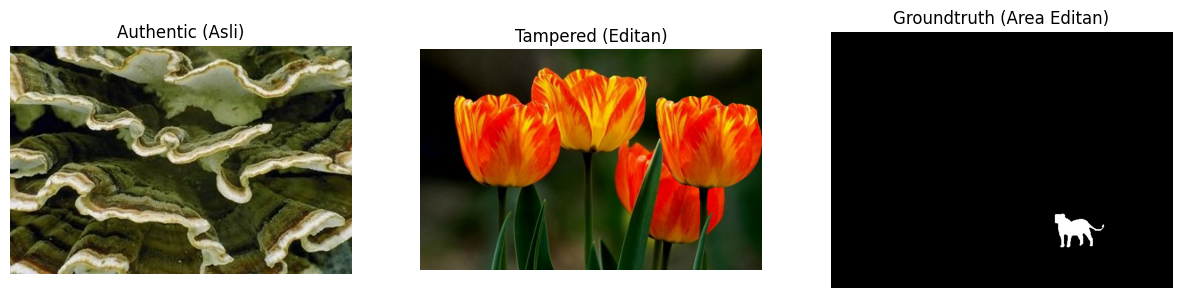

In [ ]:
import cv2
import random
from matplotlib import pyplot as plt

# ambil file random dari tiap folder
sample_auth = random.choice(os.listdir(os.path.join(base_dir, "Au")))
sample_tamp = random.choice(os.listdir(os.path.join(base_dir, "Tp")))
sample_mask = random.choice(os.listdir(os.path.join(base_dir, "CASIA 2 Groundtruth")))

# load gambar
img_auth = cv2.imread(os.path.join(base_dir, "Au", sample_auth))
img_tamp = cv2.imread(os.path.join(base_dir, "Tp", sample_tamp))
img_mask = cv2.imread(os.path.join(base_dir, "CASIA 2 Groundtruth", sample_mask), cv2.IMREAD_GRAYSCALE)

# ubah warna BGR ke RGB untuk matplotlib
img_auth = cv2.cvtColor(img_auth, cv2.COLOR_BGR2RGB)
img_tamp = cv2.cvtColor(img_tamp, cv2.COLOR_BGR2RGB)

# tampilkan
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img_auth)
plt.title("Authentic (Asli)")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img_tamp)
plt.title("Tampered (Editan)")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_mask, cmap='gray')
plt.title("Groundtruth (Area Editan)")
plt.axis('off')

plt.show()


In [ ]:
import cv2
sizes = []
folder_path = os.path.join(base_dir, "Au")
for f in random.sample(os.listdir(folder_path), 50):  # ambil 50 sample acak
    img = cv2.imread(os.path.join(folder_path, f))
    if img is not None:
        sizes.append(img.shape[:2])  # (height, width)

sizes_df = pd.DataFrame(sizes, columns=['height', 'width'])
print(sizes_df.describe())


           height       width
count   50.000000   50.000000
mean   328.960000  363.360000
std     87.472435  136.599782
min    240.000000  160.000000
25%    256.000000  256.000000
50%    256.000000  384.000000
75%    384.000000  384.000000
max    600.000000  800.000000


In [ ]:
# Melihat jenis ekstensi file di folder Tp
tp_folder = os.path.join(base_dir, "Tp")

# Ambil semua ekstensi file yang ada
extensions = [os.path.splitext(f)[1].lower() for f in os.listdir(tp_folder)]
ext_count = pd.Series(extensions).value_counts()

print("Jenis ekstensi file di folder Tp:")
print(ext_count)


Jenis ekstensi file di folder Tp:
.tif    3059
.jpg    2064
.txt       1
.db        1
Name: count, dtype: int64


In [ ]:
# Melihat jenis ekstensi file di folder Au
tp_folder = os.path.join(base_dir, "Au")

# Ambil semua ekstensi file yang ada
extensions = [os.path.splitext(f)[1].lower() for f in os.listdir(tp_folder)]
ext_count = pd.Series(extensions).value_counts()

print("Jenis ekstensi file di folder Au:")
print(ext_count)


Jenis ekstensi file di folder Au:
.jpg    7437
.bmp      54
.db        1
Name: count, dtype: int64


In [ ]:
# Melihat jenis ekstensi file di folder CASIA 2 Groundtruth
tp_folder = os.path.join(base_dir, "CASIA 2 Groundtruth")

# Ambil semua ekstensi file yang ada
extensions = [os.path.splitext(f)[1].lower() for f in os.listdir(tp_folder)]
ext_count = pd.Series(extensions).value_counts()

print("Jenis ekstensi file di folder CASIA 2 Groundtruth:")
print(ext_count)


Jenis ekstensi file di folder CASIA 2 Groundtruth:
.png    5123
Name: count, dtype: int64


In [ ]:
import sys
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import shutil
import math

# ---------- CONFIG ----------
# Jika base_dir sudah ada di namespace (dari cell sebelumnya), gunakan; kalau tidak, pakai fallback common Kaggle path
if 'base_dir' in globals():
    BASE_DIR = Path(base_dir)
else:
    BASE_DIR = Path("/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2")

FOLDERS = ["Au", "Tp", "CASIA 2 Groundtruth"]
VALID_EXT = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}
MOVE_INVALID = False   # ubah ke True jika ingin memindahkan file invalid ke folder invalid_files
INVALID_ROOT = BASE_DIR / "invalid_files"  # jika MOVE_INVALID True, file akan dipindahkan ke sini
MANIFEST_CSV = "casia_manifest.csv"  # nama file manifest yang dibuat di working dir

# ---------- helper ----------
def file_size_bytes(p: Path) -> int:
    try:
        return p.stat().st_size
    except Exception:
        return -1

def try_open_image(p: Path):
    """Return (ok, width, height). ok=False jika gagal buka atau bukan image."""
    try:
        with Image.open(p) as img:
            img.verify()  # verify quick check
        # reopen to get size after verify (some formats need re-open)
        with Image.open(p) as img:
            w, h = img.size
        return True, w, h
    except (UnidentifiedImageError, OSError, ValueError):
        return False, None, None

# ---------- scan ----------
rows = []
for folder in FOLDERS:
    folder_path = BASE_DIR / folder
    if not folder_path.exists():
        print(f"[WARN] Folder not found: {folder_path}")
        continue
    # iterate
    for entry in os.scandir(folder_path):
        if not entry.is_file():
            continue
        p = Path(entry.path)
        ext = p.suffix.lower()
        is_ext_image = ext in VALID_EXT
        fsize = file_size_bytes(p)
        can_open, width, height = (False, None, None)
        if is_ext_image:
            can_open, width, height = try_open_image(p)
        rows.append({
            "folder": folder,
            "filename": p.name,
            "filepath": str(p),
            "ext": ext,
            "is_ext_image": is_ext_image,
            "can_open": can_open,
            "width": width,
            "height": height,
            "filesize_bytes": fsize
        })

# ---------- manifest ----------
df = pd.DataFrame(rows)
# summary counts
print("Summary ekstensi (overall):")
print(df['ext'].value_counts())
print("\nJumlah file total per folder (sebelum cleaning):")
print(df['folder'].value_counts())

# identify invalid files:
# invalid = not image-ext OR image-ext but cannot open
df['valid'] = df['is_ext_image'] & df['can_open']

print("\nCounts by valid flag:")
print(df['valid'].value_counts(dropna=False))

# show a sample of invalid
invalid_df = df[~df['valid']].copy()
print(f"\nContoh file invalid (max 20): {len(invalid_df)} found")
display(invalid_df.head(20))

# save manifest csv
df.to_csv(MANIFEST_CSV, index=False)
print(f"\nManifest saved to: {MANIFEST_CSV} (rows: {len(df)})")

# ---------- optional: move invalid files ----------
if MOVE_INVALID and len(invalid_df)>0:
    print("\nMemindahkan file invalid ke folder:", INVALID_ROOT)
    for _, r in invalid_df.iterrows():
        src = Path(r['filepath'])
        dest_dir = INVALID_ROOT / r['folder']
        dest_dir.mkdir(parents=True, exist_ok=True)
        dest = dest_dir / src.name
        try:
            shutil.move(str(src), str(dest))
        except Exception as e:
            print("Failed to move", src, "->", dest, ":", e)
    print("Pemindahan selesai. (Periksa folder invalid_files)")

# ---------- counts after cleaning (if we were to only consider valid) ----------
valid_counts = df[df['valid']==True].groupby('folder').size().rename('valid_count')
total_counts = df.groupby('folder').size().rename('total_count')
summary = pd.concat([total_counts, valid_counts], axis=1).fillna(0).astype(int)
summary['invalid_count'] = summary['total_count'] - summary['valid_count']
print("\nRingkasan sebelum/sesudah (per folder):")
display(summary)

# ---------- optional: save lists of valid files per folder ----------
for folder in FOLDERS:
    out_csv = f"valid_files_{folder.replace(' ','_')}.csv"
    df_valid = df[(df['folder']==folder) & (df['valid']==True)].copy()
    df_valid.to_csv(out_csv, index=False)
    print(f"Saved {len(df_valid)} valid file entries for '{folder}' to {out_csv}")

print("\nSelesai. Lihat casia_manifest.csv dan valid_files_*.csv untuk daftar file yang valid.")


Summary ekstensi (overall):
ext
.jpg    9501
.png    5123
.tif    3059
.bmp      54
.db        2
.txt       1
Name: count, dtype: int64

Jumlah file total per folder (sebelum cleaning):
folder
Au                     7492
Tp                     5125
CASIA 2 Groundtruth    5123
Name: count, dtype: int64

Counts by valid flag:
valid
True     17737
False        3
Name: count, dtype: int64

Contoh file invalid (max 20): 3 found


,folder,filename,filepath,ext,is_ext_image,can_open,width,height,filesize_bytes,valid
4965,Au,Thumbs.db,/kaggle/input/casia-20-image-tampering-detecti...,.db,False,False,NaN,NaN,77312,False
10545,Tp,_list.txt,/kaggle/input/casia-20-image-tampering-detecti...,.txt,False,False,NaN,NaN,215175,False
10924,Tp,Thumbs.db,/kaggle/input/casia-20-image-tampering-detecti...,.db,False,False,NaN,NaN,32768,False



Manifest saved to: casia_manifest.csv (rows: 17740)

Ringkasan sebelum/sesudah (per folder):


,total_count,valid_count,invalid_count
folder,,,
Au,7492,7491,1
CASIA 2 Groundtruth,5123,5123,0
Tp,5125,5123,2


Saved 7491 valid file entries for 'Au' to valid_files_Au.csv
Saved 5123 valid file entries for 'Tp' to valid_files_Tp.csv
Saved 5123 valid file entries for 'CASIA 2 Groundtruth' to valid_files_CASIA_2_Groundtruth.csv

Selesai. Lihat casia_manifest.csv dan valid_files_*.csv untuk daftar file yang valid.


In [ ]:
# Cell: split_dataset.ipynb
from sklearn.model_selection import train_test_split

random.seed(42)

BASE_DIR = Path(base_dir)  # pakai base_dir yang sudah kamu miliki
OUT_DIR = Path("casia_split")  # hasil split akan disimpan di sini
OUT_DIR.mkdir(exist_ok=True)

# load valid file lists (yang tadi disimpan)
df_au = pd.read_csv("valid_files_Au.csv")
df_tp = pd.read_csv("valid_files_Tp.csv")

# buat label kolom
df_au['label'] = 'authentic'
df_tp['label'] = 'tampered'
df_all = pd.concat([df_au, df_tp], ignore_index=True)

# kita gunakan filename saja (kolom 'filename' dan folder)
# split stratified berdasarkan label
train_val, test = train_test_split(df_all, test_size=0.15, stratify=df_all['label'], random_state=42)
train, val = train_test_split(train_val, test_size=0.1764706, stratify=train_val['label'], random_state=42)
# 0.1764706 * 85% ≈ 15% (so overall 70/15/15)

print("Counts:", "train", len(train), "val", len(val), "test", len(test))
for split_name, df_split in [('train', train), ('val', val), ('test', test)]:
    for lbl in ['authentic', 'tampered']:
        c = (df_split['label']==lbl).sum()
        print(f"{split_name} {lbl}: {c}")

# create folders and copy files (or you can create symlink)
for split_name, df_split in [('train', train), ('val', val), ('test', test)]:
    for lbl in ['authentic','tampered']:
        target_dir = OUT_DIR / split_name / lbl
        target_dir.mkdir(parents=True, exist_ok=True)
    for _, row in df_split.iterrows():
        src = Path(row['filepath'])  # path lengkap
        dst = OUT_DIR / split_name / row['label'] / src.name
        if not dst.exists():
            shutil.copy(src, dst)  # atau shutil.copy2 to retain metadata

print("Split and copy done. Inspect casia_split/ folder.")


Counts: train 8829 val 1892 test 1893
train authentic: 5243
train tampered: 3586
val authentic: 1124
val tampered: 768
test authentic: 1124
test tampered: 769
Split and copy done. Inspect casia_split/ folder.


In [ ]:
from tqdm.notebook import tqdm

IN_TEST_DIR = Path("casia_split/test")
OUT_DEG_DIR = Path("casia_split/test_degraded")
OUT_DEG_DIR.mkdir(exist_ok=True)

# parameters
TARGET_SIZE = (224,224)
JPEG_QUALITIES = [90, 70, 40]          # compression levels
GAUSSIAN_NOISE_SIGMA = [5, 15, 30]     # standard deviation
GAUSSIAN_BLUR_K = [3,5,9]              # kernel sizes (odd)
DOWNSCALE_FACTORS = [0.5, 0.25]        # downscale then upsample

def preprocess_and_save(img, outpath):
    img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    cv2.imwrite(str(outpath), img_resized)

def add_gaussian_noise(img, sigma):
    img_f = img.astype(np.float32)
    noise = np.random.normal(0, sigma, img_f.shape).astype(np.float32)
    out = img_f + noise
    out = np.clip(out, 0, 255).astype(np.uint8)
    return out

def add_gaussian_blur(img, k):
    return cv2.GaussianBlur(img, (k,k), 0)

def jpeg_compress(img, quality):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    is_success, encimg = cv2.imencode('.jpg', img, encode_param)
    decimg = cv2.imdecode(encimg, 1)
    return decimg

def down_upscale(img, factor):
    h,w = img.shape[:2]
    new_h, new_w = max(1,int(h*factor)), max(1,int(w*factor))
    small = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    up = cv2.resize(small, (w,h), interpolation=cv2.INTER_LINEAR)
    return up

def occlude_random_block(img, block_frac=0.2):
    h,w = img.shape[:2]
    bh = int(h*block_frac); bw = int(w*block_frac)
    x = np.random.randint(0,w-bw+1)
    y = np.random.randint(0,h-bh+1)
    img2 = img.copy()
    img2[y:y+bh, x:x+bw] = 0  # black occlusion; bisa juga pake blur or patch
    return img2

# iterate test set, create degraded versions
for label in ['authentic','tampered']:
    src_dir = IN_TEST_DIR / label
    for p in tqdm(list(src_dir.glob('*'))[:1000], desc=f"processing {label}"):  # batasi dulu, hilangkan slicing untuk semua
        img = cv2.imread(str(p))
        if img is None:
            continue
        # baseline preprocessed save
        base_out = OUT_DEG_DIR / 'clean' / label
        base_out.mkdir(parents=True, exist_ok=True)
        preprocess_and_save(img, base_out / p.name)

        # JPEG qualities
        for q in JPEG_QUALITIES:
            outdir = OUT_DEG_DIR / f'jpeg_q{q}' / label
            outdir.mkdir(parents=True, exist_ok=True)
            img_j = cv2.resize(img, TARGET_SIZE)
            img_j = jpeg_compress(img_j, q)
            cv2.imwrite(str(outdir / p.name), img_j)

        # Gaussian noise
        for s in GAUSSIAN_NOISE_SIGMA:
            outdir = OUT_DEG_DIR / f'gn_sigma{s}' / label
            outdir.mkdir(parents=True, exist_ok=True)
            img_n = preprocess_and_save(add_gaussian_noise(img, s), outdir / p.name)

        # Gaussian blur
        for k in GAUSSIAN_BLUR_K:
            outdir = OUT_DEG_DIR / f'gb_k{k}' / label
            outdir.mkdir(parents=True, exist_ok=True)
            img_b = add_gaussian_blur(cv2.resize(img, TARGET_SIZE), k)
            cv2.imwrite(str(outdir / p.name), img_b)

        # downscale
        for fct in DOWNSCALE_FACTORS:
            outdir = OUT_DEG_DIR / f'down_{int(fct*100)}' / label
            outdir.mkdir(parents=True, exist_ok=True)
            img_d = down_upscale(img, fct)
            cv2.imwrite(str(outdir / p.name), cv2.resize(img_d, TARGET_SIZE))

        # occlusion
        outdir = OUT_DEG_DIR / 'occlusion' / label
        outdir.mkdir(parents=True, exist_ok=True)
        img_oc = occlude_random_block(cv2.resize(img, TARGET_SIZE), block_frac=0.25)
        cv2.imwrite(str(outdir / p.name), img_oc)

print("Pembuatan degraded test set selesai (lihat casia_split/test_degraded/)")


processing authentic:   0%|          | 0/1000 [00:00<?, ?it/s]

processing tampered:   0%|          | 0/769 [00:00<?, ?it/s]

Pembuatan degraded test set selesai (lihat casia_split/test_degraded/)


In [ ]:
!pip install torch torchvision timm scikit-learn tqdm --quiet

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm.notebook import tqdm

# reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cpu


In [ ]:
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # root_dir contains subfolders per class (authentic, tampered)
        self.root = Path(root_dir)
        self.transform = transform
        self.samples = []
        for label_idx, label in enumerate(sorted(os.listdir(self.root))):
            label_dir = self.root / label
            if not label_dir.is_dir(): continue
            for p in label_dir.glob('*'):
                self.samples.append((str(p), label))  # keep label as string

        # map string labels to ints
        self.label2idx = {'authentic': 0, 'tampered': 1}

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        y = self.label2idx[label]
        return img, y

In [ ]:
IMG_SIZE = 224
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

BATCH_SIZE = 32

train_ds = ImageFolderDataset("casia_split/train", transform=train_transforms)
val_ds   = ImageFolderDataset("casia_split/val", transform=val_transforms)
test_clean_ds = ImageFolderDataset("casia_split/test", transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_clean_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print("Counts:", len(train_ds), len(val_ds), len(test_clean_ds))


Counts: 8829 1892 1893


In [ ]:
def get_resnet50(num_classes=2, pretrained=True, freeze_backbone=True):
    model = models.resnet50(pretrained=pretrained)
    # replace head
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )
    if freeze_backbone:
        for name, param in model.named_parameters():
            if "fc" not in name:
                param.requires_grad = False
    return model

model = get_resnet50(pretrained=True, freeze_backbone=True)
model = model.to(DEVICE)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 127MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

def evaluate(model, loader):
    model.eval()
    ys = []; preds = []; probs = []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(DEVICE); y = y.to(DEVICE)
            out = model(x)
            p = torch.softmax(out, dim=1)[:,1].cpu().numpy()
            pred = out.argmax(dim=1).cpu().numpy()
            ys.extend(y.cpu().numpy().tolist())
            preds.extend(pred.tolist())
            probs.extend(p.tolist())
    return np.array(ys), np.array(preds), np.array(probs)

def compute_metrics(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else None
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "auc":auc}

In [ ]:
import re, csv, os, torch

EPOCHS = 5
base_save_path = "resnet50_baseline"
results_csv = "results_resnet50_fast.csv"

# 🔹 Cek file CSV
if not os.path.exists(results_csv):
    with open(results_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "loss", "val_acc", "val_prec", "val_rec", "val_f1", "val_auc", "best_flag"])

# 🔹 Cari model terbaik lama
prev_best_model = None
best_val_f1 = 0.0
for f in os.listdir("."):
    if f.startswith(base_save_path) and "best" in f and f.endswith(".pth"):
        prev_best_model = f

if prev_best_model:
    print(f"🔄 Found previous best model: {prev_best_model}")
    # Modify the regex to match float values correctly
    match = re.search(r"f1([0-9.]+)", prev_best_model)
    if match:
        # Ensure the captured group is stripped of any trailing periods before conversion
        best_val_f1 = float(match.group(1).rstrip('.'))
    print(f"💾 Previous best_val_f1: {best_val_f1:.4f}")
    best_model_path = prev_best_model
else:
    print("🚀 No previous best model found — starting fresh.")
    best_model_path = None

# 🔧 Training loop
for ep in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0
    for xb, yb in tqdm(train_loader, desc=f"Train ep{ep}", leave=False):
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)

    # 🧪 Validation
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(DEVICE, non_blocking=True)
            out = model(xb)
            preds = torch.argmax(out, 1)
            probs = torch.softmax(out, 1)[:, 1]
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    metrics = compute_metrics(y_true, y_pred, y_prob)
    print(f"Ep {ep} | loss={epoch_loss:.4f} | F1={metrics['f1']:.4f} | Acc={metrics['acc']:.4f}")

    # 💾 Bandingkan dengan best model
    if metrics["f1"] > best_val_f1:
        best_val_f1 = metrics["f1"]
        # Format the filename to avoid trailing periods if the F1 score ends with .0
        best_model_path = f"{base_save_path}_best_ep{ep}_f1{best_val_f1:.4f}.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ New best model saved: {best_model_path}")
        best_flag = "✅"
    else:
        # ⚡ Jika hasil turun, kembalikan model ke versi terbaik sebelumnya
        if best_model_path and os.path.exists(best_model_path):
            model.load_state_dict(torch.load(best_model_path))
            print(f"🔁 Restored previous best model (F1={best_val_f1:.4f})")
        best_flag = ""

    # ✍️ Log hasil
    with open(results_csv, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            ep,
            round(epoch_loss, 6),
            round(metrics["acc"], 6),
            round(metrics["prec"], 6),
            round(metrics["rec"], 6),
            round(metrics["f1"], 6),
            round(metrics["auc"], 6) if metrics["auc"] else None,
            best_flag
        ])

print(f"\n🏁 Training selesai — Best F1 final: {best_val_f1:.4f}")
print(f"📊 Semua hasil tersimpan di: {results_csv}")

🚀 No previous best model found — starting fresh.


Train ep1:   0%|          | 0/276 [00:00<?, ?it/s]

Ep 1 | loss=0.6454 | F1=0.3507 | Acc=0.6517
✅ New best model saved: resnet50_baseline_best_ep1_f10.3507.pth


Train ep2:   0%|          | 0/276 [00:00<?, ?it/s]

Ep 2 | loss=0.6062 | F1=0.6723 | Acc=0.7125
✅ New best model saved: resnet50_baseline_best_ep2_f10.6723.pth


Train ep3:   0%|          | 0/276 [00:00<?, ?it/s]

Ep 3 | loss=0.6014 | F1=0.5008 | Acc=0.6871
🔁 Restored previous best model (F1=0.6723)


Train ep4:   0%|          | 0/276 [00:00<?, ?it/s]

Ep 4 | loss=0.6026 | F1=0.6134 | Acc=0.7215
🔁 Restored previous best model (F1=0.6723)


Train ep5:   0%|          | 0/276 [00:00<?, ?it/s]

Ep 5 | loss=0.5985 | F1=0.6467 | Acc=0.7188
🔁 Restored previous best model (F1=0.6723)

🏁 Training selesai — Best F1 final: 0.6723
📊 Semua hasil tersimpan di: results_resnet50_fast.csv


In [ ]:
# load best model
# Use the best_model_path variable from the previous training cell
model.load_state_dict(torch.load(best_model_path))
model.eval()

# evaluate test_clean
y_t, p_t, prob_t = evaluate(model, test_loader)
m_clean = compute_metrics(y_t, p_t, prob_t)
print("Test clean:", m_clean)

# evaluate all degraded variants
deg_root = Path("casia_split/test_degraded")
results = {}
for variant_dir in sorted([d for d in deg_root.iterdir() if d.is_dir()]):
    # Skip if no files found in the directory
    if not any(variant_dir.iterdir()):
        print(f"Skipping empty directory: {variant_dir.name}")
        continue

    ds = ImageFolderDataset(str(variant_dir), transform=val_transforms)
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    yv, pv, pr = evaluate(model, loader)
    results[variant_dir.name] = compute_metrics(yv, pv, pr)
    print(variant_dir.name, results[variant_dir.name])

Test clean: {'acc': 0.6973058637083994, 'prec': 0.6113636363636363, 'rec': 0.6996098829648895, 'f1': 0.6525166767738023, 'auc': np.float64(0.7635187353359032)}
clean {'acc': 0.7071791972866026, 'prec': 0.6467836257309941, 'rec': 0.7191157347204161, 'f1': 0.6810344827586207, 'auc': np.float64(0.7788972691807541)}
down_25 {'acc': 0.6336913510457886, 'prec': 0.6763848396501457, 'rec': 0.3016905071521456, 'f1': 0.4172661870503597, 'auc': np.float64(0.7008946684005202)}
down_50 {'acc': 0.6902204635387225, 'prec': 0.6567375886524822, 'rec': 0.6020806241872562, 'f1': 0.6282225237449118, 'auc': np.float64(0.755373211963589)}
gb_k3 {'acc': 0.6698699830412662, 'prec': 0.6403641881638846, 'rec': 0.5487646293888166, 'f1': 0.5910364145658263, 'auc': np.float64(0.7369505851755526)}
gb_k5 {'acc': 0.6472583380440927, 'prec': 0.6365348399246704, 'rec': 0.43953185955786733, 'f1': 0.52, 'auc': np.float64(0.709487646293888)}
gb_k9 {'acc': 0.6280384397964952, 'prec': 0.6130346232179226, 'rec': 0.3914174252

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

sns.set(style="whitegrid", font_scale=1.1)
def build_results_for_variants(model, deg_root="casia_split/test_degraded",
                               val_transforms=None, BATCH_SIZE=32, device=None):
    from torch.utils.data import DataLoader
    res = {}
    deg_root = Path(deg_root)
    variant_dirs = sorted([d for d in deg_root.iterdir() if d.is_dir()])
    for variant_dir in variant_dirs:
        ds = ImageFolderDataset(str(variant_dir), transform=val_transforms)
        loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        y_true, y_pred, y_prob = evaluate(model, loader)
        res[variant_dir.name] = compute_metrics(y_true, y_pred, y_prob)
        # optionally store raw arrays for ROC/PR/CM plotting
        res[variant_dir.name].update({
            "y_true": y_true, "y_pred": y_pred, "y_prob": y_prob
        })
        print("Done:", variant_dir.name, res[variant_dir.name])
    return res

# Jika belum punya 'results', buat sekarang (memerlukan model ter-load dan val_transforms)
# device/DEVICE harus sesuai
# results = build_results_for_variants(model, deg_root="casia_split/test_degraded", val_transforms=val_transforms, BATCH_SIZE=32, device=DEVICE)

# ---------- 1) Plot training curves (jika ada history dict) ----------
def plot_training_history(history, savepath=None):
    # history: dict dengan keys 'train_loss','val_loss','val_f1','val_acc' (list per epoch)
    epochs = range(1, len(history['train_loss'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], '-o', label='train_loss')
    plt.plot(epochs, history['val_loss'], '-o', label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss per epoch')
    plt.subplot(1,2,2)
    if 'val_f1' in history:
        plt.plot(epochs, history['val_f1'], '-o', label='val_f1')
    if 'val_acc' in history:
        plt.plot(epochs, history['val_acc'], '-o', label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Value'); plt.legend(); plt.title('Val metrics per epoch')
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200)
    plt.show()

# contoh pemakaian:
# plot_training_history(history, savepath="training_history.png")


# ---------- 2) Bar chart per-variant (acc / f1 / auc) ----------
def plot_metrics_bar(results, metrics=['acc','f1','auc'], top_n=None, figsize=(10,5), savepath=None):
    # results: dict variant -> dict(metrics...)
    rows = []
    for variant, d in results.items():
        row = {"variant": variant}
        for m in metrics:
            row[m] = float(d.get(m, np.nan))
        rows.append(row)
    df = pd.DataFrame(rows).sort_values(metrics[0], ascending=False)
    if top_n:
        df = df.head(top_n)
    df_melt = df.melt(id_vars='variant', value_vars=metrics, var_name='metric', value_name='value')
    plt.figure(figsize=figsize)
    sns.barplot(data=df_melt, x='variant', y='value', hue='metric')
    plt.xticks(rotation=45, ha='right')
    plt.title('Performa per variant (test_degraded & clean)')
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200)
    plt.show()
    return df


# ---------- 3) Confusion matrix heatmap untuk satu variant ----------
def plot_confusion_matrix_for_variant(results, variant_name, labels=['authentic','tampered'], savepath=None):
    data = results.get(variant_name)
    if data is None or 'y_true' not in data:
        raise ValueError("Variant not found or y_true/y_pred not in results. Recompute with build_results_for_variants.")
    cm = confusion_matrix(data['y_true'], data['y_pred'])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(f'Confusion Matrix: {variant_name}')
    if savepath:
        plt.savefig(savepath, dpi=200)
    plt.show()


# ---------- 4) ROC & PR curve plotting ----------
def plot_roc_pr_for_variants(results, variants=None, savepath=None):
    plt.figure(figsize=(12,5))
    # ROC
    plt.subplot(1,2,1)
    for variant in (variants or list(results.keys())):
        d = results[variant]
        if 'y_prob' not in d:
            continue
        fpr, tpr, _ = roc_curve(d['y_true'], d['y_prob'])
        roc_auc = auc(fpr,tpr)
        plt.plot(fpr, tpr, label=f"{variant} (AUC={roc_auc:.2f})")
    plt.plot([0,1],[0,1],'k--', alpha=0.5)
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves'); plt.legend(loc='lower right')
    # PR
    plt.subplot(1,2,2)
    for variant in (variants or list(results.keys())):
        d = results[variant]
        if 'y_prob' not in d:
            continue
        prec, rec, _ = precision_recall_curve(d['y_true'], d['y_prob'])
        auc_pr = np.trapz(prec, rec)
        plt.plot(rec, prec, label=f"{variant} (AP~{auc_pr:.2f})")
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curves'); plt.legend(loc='lower left')
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200)
    plt.show()


# ---------- 5) Plot performa vs tingkat degradasi (contoh: jpeg quality atau noise sigma) ----------
# Asumsi: variant names mengandung indikator seperti 'jpeg_q90', 'jpeg_q70', 'gn_sigma5', 'gn_sigma15', ...
def plot_perf_vs_degrad(results, metric='f1', kind='jpeg', savepath=None):
    # filter variants by kind
    rows = []
    for k,v in results.items():
        if kind in k:
            # parse numeric from name
            import re
            nums = re.findall(r'\d+', k)
            val = float(nums[-1]) if nums else np.nan
            rows.append({'variant':k, 'param':val, metric: v.get(metric, np.nan)})
    if not rows:
        print("No variants found for kind =", kind)
        return
    df = pd.DataFrame(rows).sort_values('param', ascending=(kind!='jpeg'))  # for jpeg higher quality -> better, flip if needed
    plt.figure(figsize=(8,4))
    plt.plot(df['param'], df[metric], '-o')
    plt.xlabel('parameter (e.g. quality or sigma)'); plt.ylabel(metric)
    plt.title(f'{metric} vs {kind}')
    plt.grid(True)
    if savepath:
        plt.savefig(savepath, dpi=200)
    plt.show()


In [ ]:
results = build_results_for_variants(
    model,
    deg_root="casia_split/test_degraded",
    val_transforms=val_transforms,
    BATCH_SIZE=32,
    device=DEVICE
)


Done: clean {'acc': 0.7071791972866026, 'prec': 0.6467836257309941, 'rec': 0.7191157347204161, 'f1': 0.6810344827586207, 'auc': np.float64(0.7788972691807541), 'y_true': array([0, 0, 0, ..., 1, 1, 1]), 'y_pred': array([1, 0, 0, ..., 0, 1, 1]), 'y_prob': array([0.53343153, 0.17617501, 0.21801345, ..., 0.44351709, 0.79814678,
       0.56948149])}
Done: down_25 {'acc': 0.6336913510457886, 'prec': 0.6763848396501457, 'rec': 0.3016905071521456, 'f1': 0.4172661870503597, 'auc': np.float64(0.7008946684005202), 'y_true': array([0, 0, 0, ..., 1, 1, 1]), 'y_pred': array([0, 0, 0, ..., 0, 1, 1]), 'y_prob': array([0.32220021, 0.12729578, 0.13423125, ..., 0.40934935, 0.66043872,
       0.56772488])}
Done: down_50 {'acc': 0.6902204635387225, 'prec': 0.6567375886524822, 'rec': 0.6020806241872562, 'f1': 0.6282225237449118, 'auc': np.float64(0.755373211963589), 'y_true': array([0, 0, 0, ..., 1, 1, 1]), 'y_pred': array([0, 0, 0, ..., 0, 1, 1]), 'y_prob': array([0.41681156, 0.1704995 , 0.16298698, ..., 0

In [ ]:
results_df = pd.DataFrame(results).T
display(results_df[['acc','f1','auc']])


,acc,f1,auc
clean,0.707179,0.681034,0.778897
down_25,0.633691,0.417266,0.700895
down_50,0.69022,0.628223,0.755373
gb_k3,0.66987,0.591036,0.736951
gb_k5,0.647258,0.52,0.709488
gb_k9,0.628038,0.477778,0.666845
gn_sigma15,0.562465,0.643974,0.71301
gn_sigma30,0.557942,0.639299,0.698042
gn_sigma5,0.68909,0.698795,0.784904
jpeg_q40,0.6303,0.42732,0.698257


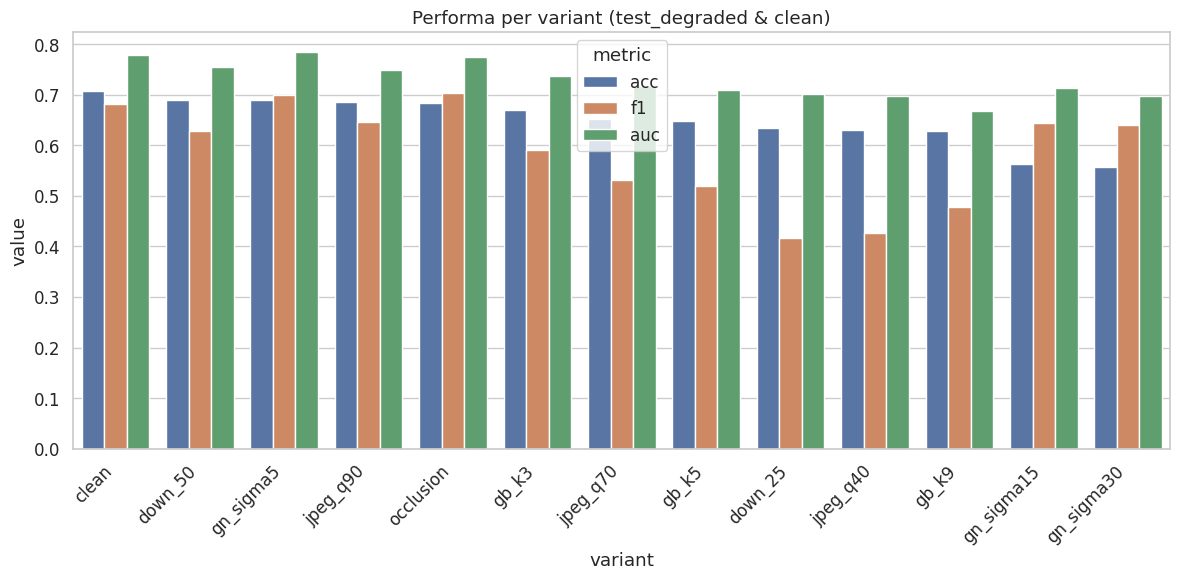

,variant,acc,f1,auc
0,clean,0.707179,0.681034,0.778897
2,down_50,0.690220,0.628223,0.755373
8,gn_sigma5,0.689090,0.698795,0.784904
11,jpeg_q90,0.685698,0.645408,0.748389
12,occlusion,0.683437,0.702760,0.774688
3,gb_k3,0.669870,0.591036,0.736951
10,jpeg_q70,0.652346,0.530892,0.717246
4,gb_k5,0.647258,0.520000,0.709488
1,down_25,0.633691,0.417266,0.700895
9,jpeg_q40,0.630300,0.427320,0.698257


In [ ]:
plot_metrics_bar(results, metrics=['acc','f1','auc'], figsize=(12,6))


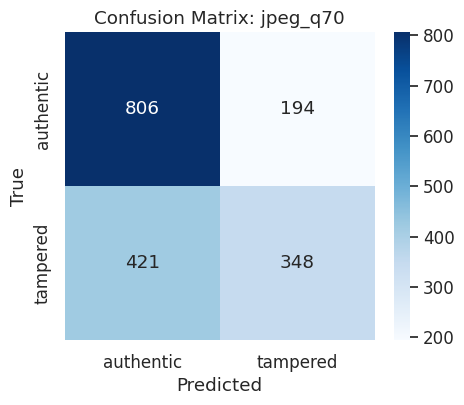

In [ ]:
plot_confusion_matrix_for_variant(results, "jpeg_q70")


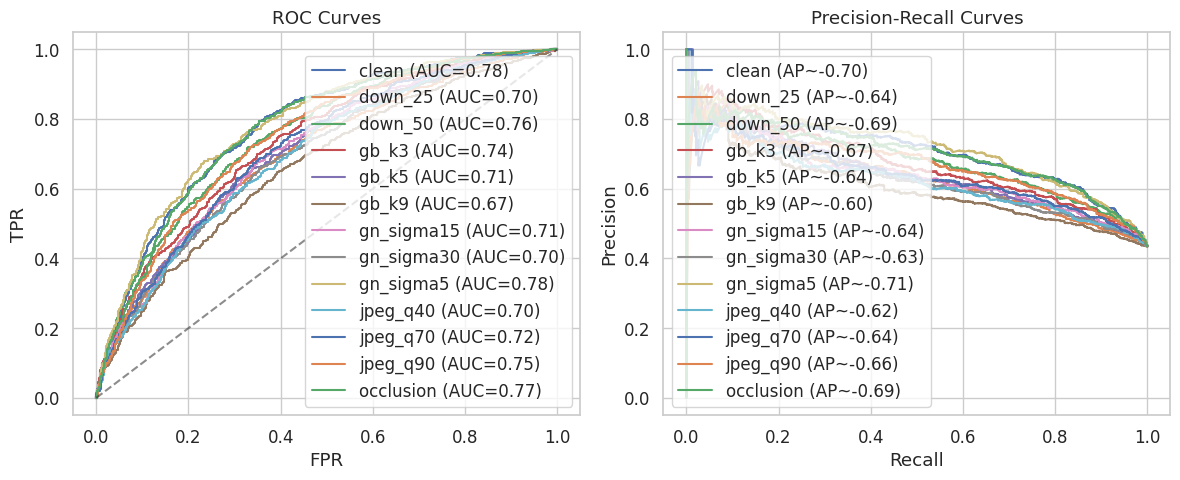

In [ ]:
plot_roc_pr_for_variants(results)


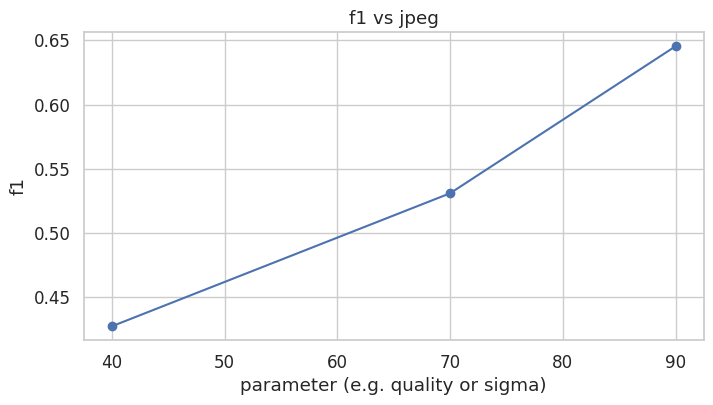

In [ ]:
plot_perf_vs_degrad(results, metric='f1', kind='jpeg')


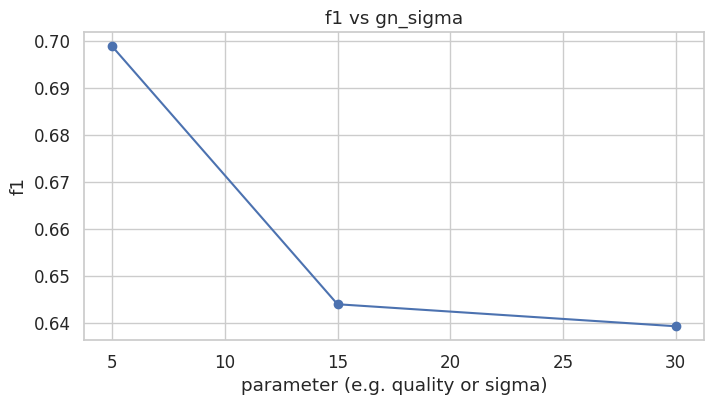

In [ ]:
plot_perf_vs_degrad(results, metric='f1', kind='gn_sigma')
